Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg

# Introducción

En este trabajo buscamos obtener modelos de redes neuronales artificiales, basados en aprendizaje no supervisado, que logren aprender de un conjunto de documentos con descripciones de texto de compañías brasileñas. La idea es que lo modelos no solo logren aprender estos datos, sino también generalizar sobre nuevas instancias. 

In [2]:
%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import requests

r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

A continuación separamos las categoría de los atributos de cada documento. Además, normalizamos dichos atributos.

In [3]:
categories = data[:,0]

X = data[:,1:]

X = (X - X.mean(axis=0)) / X.std()

# Reducción de dimensión

Nuestro primer objetivo será obtener dos modelos de redes neuronales artificiales que logren reducir la dimensión de los documentos en el conjunto de datos. Éstos van a diferir en la regla utilizada para actualizar los pesos: uno utilizará la **Regla de Oja** y otro la **Regla de Sanger**.

En particular, dada una instancia de dimensión $N$, queremos encontrar una representación de dimensión $M = 9$. Esto se logra llevando las instancias al subespacio generado por sus $9$ primeras componentes principales.

In [4]:
P = X.shape[0]  # Cantidad de instancias
N = X.shape[1]  # Dimensión de entrada
M = 9           # Dimensión de salida

Como criterio de corte para los algoritmos utilizaremos la ortogonalidad, y variaremos el valor óptimo que debe llegar a tomar ésta para encontrar el mejor modelo.

In [5]:
def orthogonality(W: np.ndarray) -> float:
    M = W.shape[1]
    return np.sum(np.abs(np.dot(W.T, W) - np.identity(M))) / 2


Inicializamos los pesos con valores al azar, con una distribución normal:

In [6]:
def initialize_weights(N: int, M: int) -> np.ndarray:
    return np.random.RandomState(seed=42).normal(0, 0.1, (N, M))

Definimos los algoritmos a utilizar para calcular la corrección de los pesos:

In [7]:
def oja_correction(W: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    Z = np.dot(Y, W.T)
    return np.outer(X - Z, Y)


def sanger_correction(W: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    M = W.shape[1]
    D = np.triu(np.ones((M, M)))
    Z = np.dot(W, Y.T * D)
    return (X.T - Z) * Y

Por último, definimos la función que utilizaremos para entrenar la red, en la cual se puede variar el método de cálculo de corrección de los pesos. Ésta, además de reducir la dimensión de los datos, realiza un gráfico de cómo (idealmente) decae la ortogonalidad en cada época de entrenamiento.

Aclaración: usamos la librería `typing` para que queden más claros los tipos que toma la función.

In [8]:
from typing import Callable

CorrectionFunc = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]

def PCA_train(
    X: np.ndarray,
    M: int,
    corr: CorrectionFunc,
    *,
    epochs: int = 1000,
    ort_threshold: float = 0.01,
    lr: float = 0.001,
) -> np.ndarray:
    
    fig = plt.figure()

    W = initialize_weights(X.shape[1], M)
    current_lr = lr
    orthogonalities = []

    for t in range(1, epochs + 1):
        for i in range(X.shape[0]):
            x = X[i].reshape(1, -1)
            Y = np.dot(x, W)
            W += current_lr * corr(W, x, Y)

        o = orthogonality(W)
        orthogonalities.append(o)

        if o < ort_threshold:
            break

        if t % 100 == 0:
            print(f"epoch: {t:03}, ortogonalidad: {o}")

        current_lr = lr / t
        
    plt.plot(orthogonalities)
    plt.show()

    return W

Además, definimos una función para poder graficar los resultados, usando figuras en el espacio $R^3$.

In [9]:
def graphic_representation(Y: np.ndarray) -> any:
    AX_LIM = 20

    fig = plt.figure(figsize=(10, 10))

    for i in range(3):
        compA, compB, compC = 3 * i, 3 * i + 1, 3 * i + 2

        xyz = fig.add_subplot(1, 3, i + 1, projection="3d")
        xyz.set_xlim(-AX_LIM, AX_LIM)
        xyz.set_ylim(-AX_LIM, AX_LIM)
        xyz.set_zlim(-AX_LIM, AX_LIM)
        xyz.scatter3D(Y[:, compA], Y[:, compB], Y[:, compC], c=categories, cmap='Set1')

        # Labeling
        xyz.set_xlabel(f"PC{compA}")
        xyz.set_ylabel(f"PC{compB}")
        xyz.set_zlabel(f"PC{compC}")

        xyz.set_title(f"PCA Oja - PC{compA} vs PC{compB} vs PC{compC}")

    fig.tight_layout(pad=5.0)

    plt.show()

## Regla de Oja

epoch: 100, ortogonalidad: 0.02237650786742844
epoch: 200, ortogonalidad: 0.011171113056730023


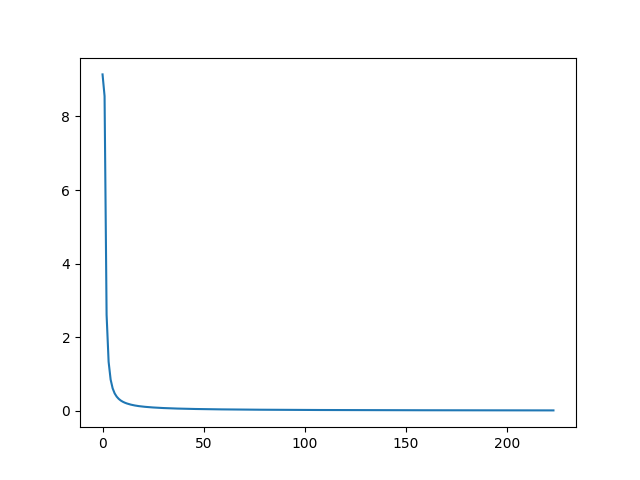

In [10]:
W_oja = PCA_train(X, M, oja_correction)

In [11]:
Y_oja = np.dot(X, W_oja)

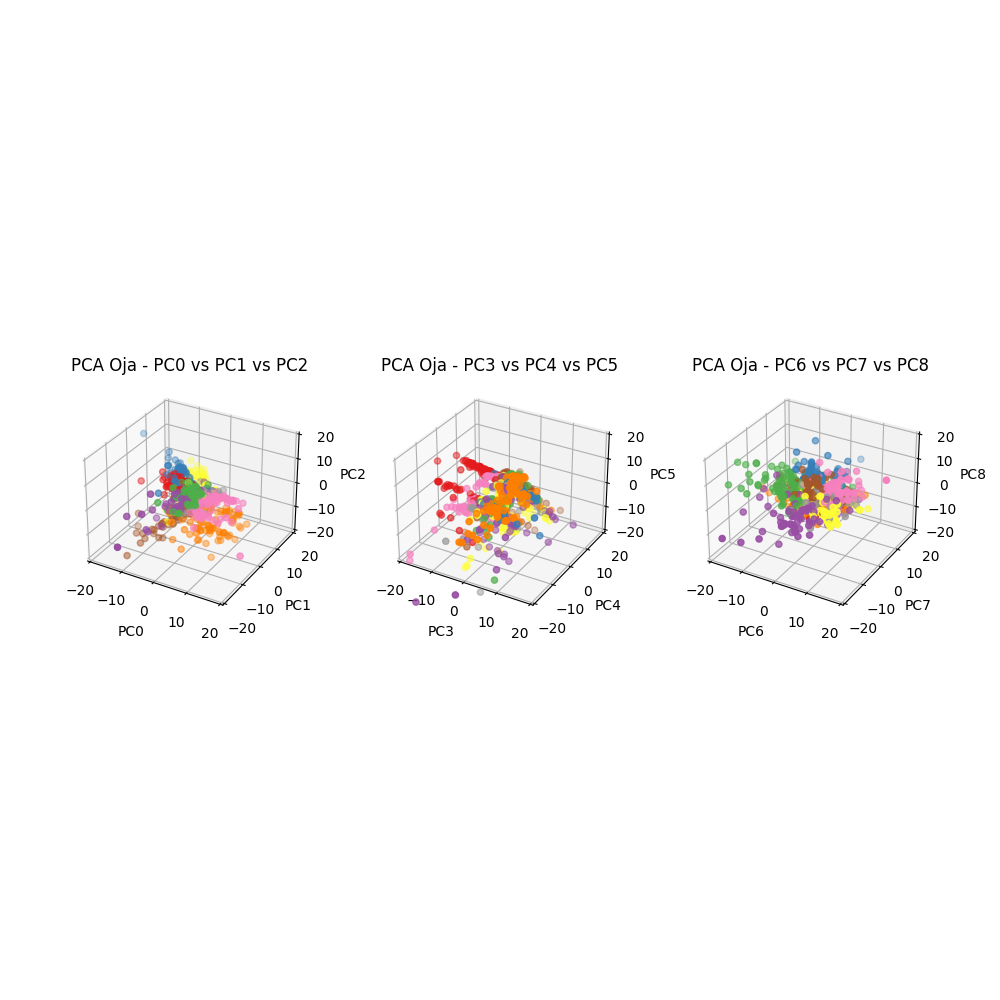

In [12]:
graphic_representation(Y_oja)

## Regla de Sanger

epoch: 100, ortogonalidad: 0.11675905431371349
epoch: 200, ortogonalidad: 0.058943148320406966
epoch: 300, ortogonalidad: 0.03942290972682909
epoch: 400, ortogonalidad: 0.029617168591650013
epoch: 500, ortogonalidad: 0.023718930130079884
epoch: 600, ortogonalidad: 0.019780456135250014
epoch: 700, ortogonalidad: 0.016964080547488145
epoch: 800, ortogonalidad: 0.014850009482726348
epoch: 900, ortogonalidad: 0.013204641105929532
epoch: 1000, ortogonalidad: 0.011887639837275782


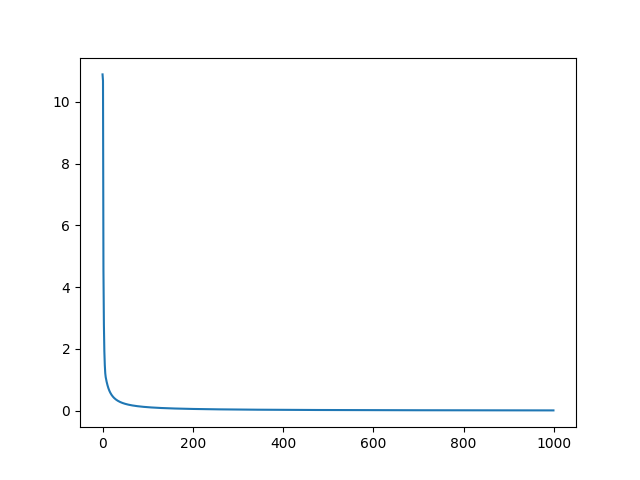

In [13]:
W_sanger = PCA_train(X, M, sanger_correction)

In [14]:
Y_sanger = np.dot(X, W_sanger)

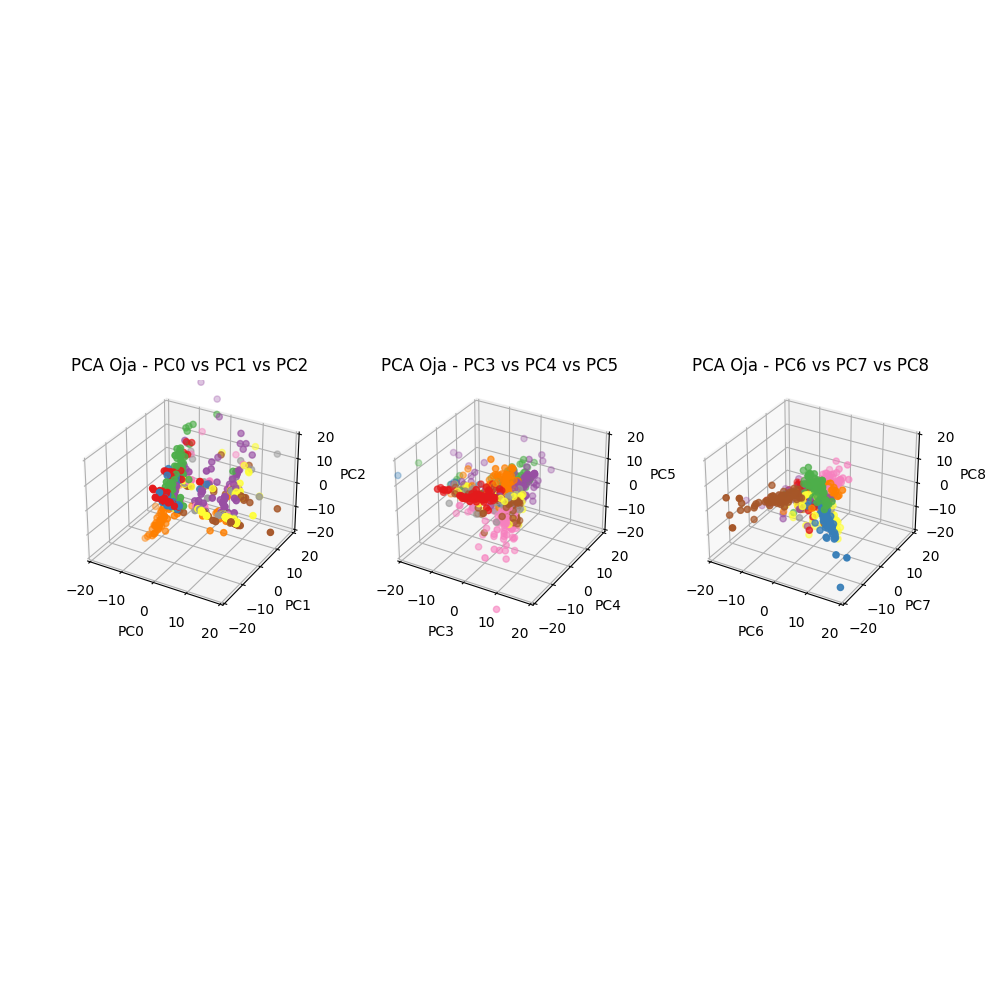

In [15]:
graphic_representation(Y_sanger)

Luego de experimentar con distintos hiperparámetros de entrenamiento, llegamos a las siguientes conclusiones:

- `epochs`: para la cantidad de épocas decidimos usar $1000$, ya que es un número lo suficientemente grande, con el que obtuvimos buenos resultados (se puede ver que baja la ortogonalidad considerablemente), pero no tan alto como para hacer que el entrenamiento tarde demasiado tiempo. Probamos también con menos y más épocas, desde $100$ hasta $5000$, pero, por ejemplo, con $500$ épocas no había una diferencia de tiempo siginificativa comparado con $1000$ y la ortogonalidad final era más alta, mientras que con $5000$ épocas bajaba la ortogonaldidad pero no compensaba con el aumento en tiempo de entrenamiento.

- `ort_threshold`: en el caso de la cota para la ortogonalidad creemos que $0.01$ es un número los suficientemente chico (es decir, cercano a cero), pero el cual no se tarda demasiado en alcanzar.

- `lr`: para que la convergencia del entrenamiento sea más rápida decidimos utilizar un *learning rate* dinámico, es decir, disminuirlo en cada iteración. Esto lo hacemos dividiéndolo por la *epoch* actual. Luego de probar varios valores, obtuvimos los mejores resultados con $lr = 0.001$. Al inicializar el *learning rate* en un valor mayor, los resultados no eran convincentes. En cambio, al disminuir su valor inicial, el entrenamiento era más eficiente en términos de tiempo, pero la ortogonalidad final aumentaba considerablemente. Sin embargo, probamos también aumentando la cantidad de épocas y comenzado con un coeficiente de aprendizaje menor, lo cual produjo mejores resultados, a costa de un mayor tiempo de entrenamiento.



Por otra parte, podemos realizar una comparación entre ambas reglas de aprendizaje utilizadas. En general, la Regla de Oja produce, para este conjunto de datos, mejores resultados en una menor cantidad de tiempo. En todos los casos, usar la Regla de Sanger hacía que el modelo tome más tiempo en convenger, pero siempre mantenía o aumentaba la ortogonalidad final.

# Mapeo de características

A continuación, buscamos un modelo de mapeo de características auto-organizado, cuyo objetivo es clasificar los documentos en una cuadrícula bidimensional, donde cada unidad de la cuadrícula representa una combinación específica de características de entrada.

Definimos una función para inicializar los pesos:

In [16]:
def initialize_weights(N, M):
    return np.random.RandomState(seed=1221).normal(0, 1, (M,M,N))

La función `SOM_train` entrena un Mapa Auto-Organizado (SOM, por sus siglas en inglés) utilizando los datos de entrada `X`.

Se inicializa la matriz de activación de salida `Y` con ceros y la matriz de pesos `W` utilizando la función `initialize_weights`. El tamaño de la matriz de pesos `W` se determina según la cantidad de características en los datos de entrada y el parámetro $M$ (tamaño de la cuadrícula).

Luego, el código entra en un bucle de entrenamiento que itera durante el número de épocas especificadas. Dentro de cada época, se recorren todos los documentos en los datos de entrada.

Para cada documento, el código realiza las siguientes operaciones:

- Calcula la diferencia entre el vector de características del documento y los pesos de todas las unidades en el mapa.
- Calcula la norma euclidiana de las diferencias para obtener las distancias entre el documento y cada unidad del SOM.
- Encuentra la posición de la unidad con la distancia mínima, lo que indica la unidad más cercana al documento.
- Activa la unidad más cercana `p`, estableciendo `Y[p]` en 1, quedando en cero todas las demás unidades en `Y` (*winner-takes-all*).
- Calcula la tasa de aprendizaje y el radio de influencia para esta iteración según la época actual.
- Construye una matriz `im` que contiene las coordenadas de las unidades en el SOM.
- Calcula las distancias entre cada unidad y la unidad más cercana para determinar el factor de influencia `pf`.
- Actualiza los pesos `W` basándose en la tasa de aprendizaje, el factor de influencia y la diferencia entre el documento y los pesos.

Finalmente, se devuelven los pesos entrenados `W`.

In [17]:
M = 6

def error_and_index(x, W):
    e = x - W
    n = np.linalg.norm(e, axis=2)
    p = np.unravel_index(np.argmin(n), n.shape)
    
    return e,p



def SOM_train(
    X: np.ndarray,
    epochs: int = 100,
    lr_st = 0.1,
    lr_dr = 0.001,
    ir_st = 3,
    ir_dr = 0.05
) -> np.ndarray:

    Y = np.zeros((M,M))
    W = initialize_weights(X.shape[1], M)

    for t in range(epochs):
        for i in range(X.shape[0]):
            
            e, p = error_and_index(X[i], W)

            Y[:] = 0
            Y[p] = 1

            lr = lr_st * np.exp(-t * lr_dr)
            ir = ir_st * np.exp(-t * ir_dr)

            il = [[(x, Y) for Y in range(M)] for x in range(M)]
            im = np.array(il)

            d = np.linalg.norm(im-p, axis=2)

            pf = np.exp(-d/(2*np.square(ir))).reshape((M,M,1))

            W +=  lr * pf * e
        
        if t % 10 == 0:
            print(f"epoch: {t:03}")

    return W



In [18]:
W = SOM_train(X)

epoch: 000
epoch: 010
epoch: 020
epoch: 030
epoch: 040
epoch: 050
epoch: 060
epoch: 070
epoch: 080
epoch: 090


Una vez obtenidos los pesos `W`, podemos usarlos para generar un mapa de características en el cual se visualizan las categorías más frecuentes asignadas a cada unidad del SOM. 

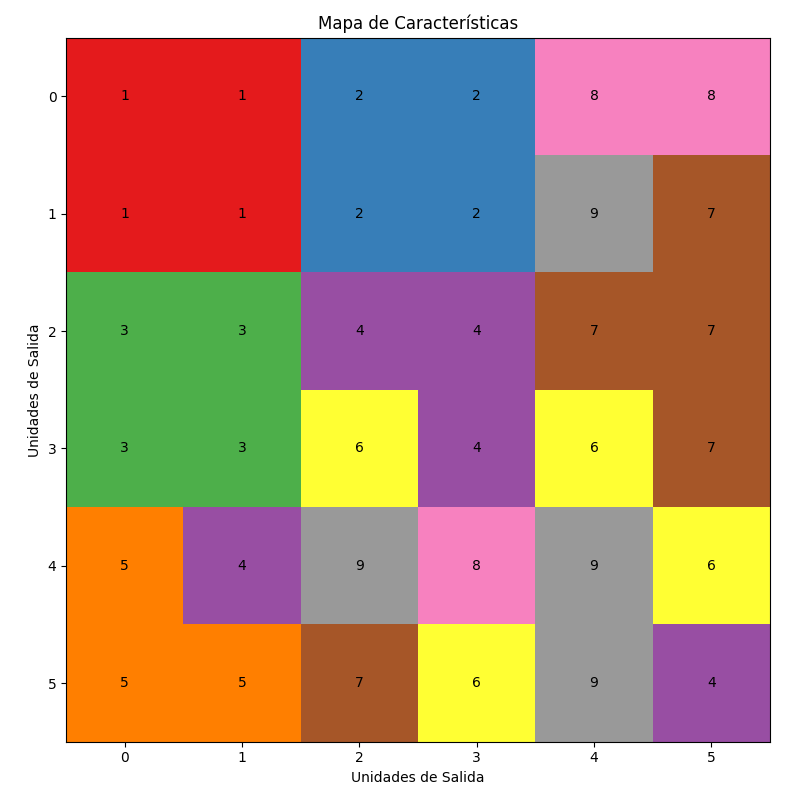

In [19]:

predicted_categories = np.zeros((M, M), dtype=int)
predicted_categories_counter = np.zeros((M,M,10), dtype=int)

for i in range(X.shape[0]):

    _, p = error_and_index(X[i], W)

    predicted_categories_counter[p][categories.astype(int)[i]] += 1


for i in range(len(predicted_categories_counter)):
    for j in range(len(predicted_categories_counter[i])):
        predicted_categories[i][j] = np.argmax(predicted_categories_counter[i][j])


fig, ax = plt.subplots(figsize=(8, 8))

# Etiquetar cada unidad de salida con la categoría que más la activa
for i in range(predicted_categories.shape[0]):
    for j in range(predicted_categories.shape[1]):
        category = predicted_categories[i, j]
        ax.text(j, i, str(category), ha='center', va='center', color='black')


ax.imshow(predicted_categories, cmap='Set1')

plt.title('Mapa de Características')
plt.xlabel('Unidades de Salida')
plt.ylabel('Unidades de Salida')
plt.tight_layout()
plt.show()


El siguiente gráfico muestra los clusters resultantes en el mapa de características con la adición de ruido aleatorio. Cada punto en el gráfico representa un documento, y su posición en el gráfico refleja la ubicación en el mapa de características. Los puntos se colorean según las categorías, lo que permite visualizar la distribución y agrupación de los datos en el mapa de características, agregando ruido para facilitar la visualización de puntos de distintas categorías.

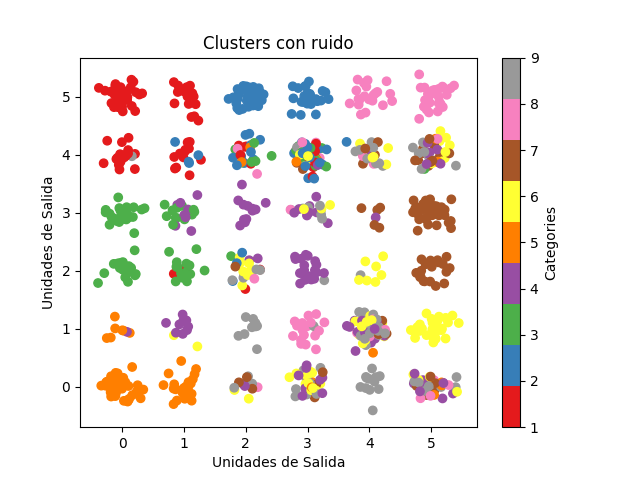

In [21]:
pred_x = np.zeros((X.shape[0],))
pred_y = np.zeros((X.shape[0],))

for i in range(X.shape[0]):
    
    _, p = error_and_index(X[i], W)

    pred_x[i] = p[1]
    pred_y[i] = M - p[0] - 1

jitter_var = 0.15


jitter_x = pred_x + np.random.normal(0, jitter_var, len(pred_x))
jitter_y = pred_y + np.random.normal(0, jitter_var, len(pred_y))

fig, ax = plt.subplots()
scatter = ax.scatter(jitter_x, jitter_y, c=categories, cmap="Set1")
ax.set_xlabel('Unidades de Salida')
ax.set_ylabel('Unidades de Salida')
ax.set_title('Clusters con ruido')

# Add colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Categories')

plt.show()

Luego de probar con muchos variantes de los hiperparámetros, nos pareció que el modelo llegaba a los mejores resultados con $100$ épocas, $M=6$ unidades de salida, un *learning rate* inicial de $0.1$, con un *decay rate* para éste de $0.001$, y $3$ de *influence ratio* incial, el cual decae a una tasa de $0.05$.

Nos extrañó que aumentar la cantidad de épocas no solo hiciera al algoritmo mucho más lento (lo cual era esperado), sino que no produjo una mejora en los resultados. Por otro lado, tomar $5$ unidades de salida en vez de $6$ generaba resultados similares a los obtenidos, pero aumentar o disminuir demasiado este valor los empeoraba. Respecto a los demás hiperparámetros, se probó con muchos valores distintos, y leves cambios en ellos producían grandes cambios en los resultados. 

Nuestra conclusión sobre los resultados obtenidos durante la experimentación es que, mientras que parte de las categorías se pueden separar linealmente, hay ciertas regiones (probablemente en las fronteras entre éstas) donde esto se dificulta.